### CMB Assigment 2 Program ###

In [1]:
# Program, run imports
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import seaborn as sns
import requests
sns.set(style="darkgrid")

Create Pandas Dataframe

In [2]:
#df = pd.read_csv("data/21-12-23_complete.csv")
# data_folder = "/Users/Fabian/Desktop/"
data_folder = "C:/Users/maxim/Documents/RaspData/Preprocessed Data/"
#df = pd.read_csv(data_folder + "test.csv")
df = pd.read_csv(data_folder + "2022-01-04_complete.csv")
print(df)
# ['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info', 'dst port']


             No.                        Time  \
0              1  2022-01-04 01:36:02,869923   
1              2  2022-01-04 01:36:02,876443   
2              3  2022-01-04 01:36:02,880662   
3              4  2022-01-04 01:36:02,968472   
4              5  2022-01-04 01:36:03,054578   
...          ...                         ...   
1211455  1211456  2022-01-05 01:35:10,677165   
1211456  1211457  2022-01-05 01:35:10,677351   
1211457  1211458  2022-01-05 01:35:10,677549   
1211458  1211459  2022-01-05 01:35:10,677743   
1211459  1211460  2022-01-05 01:35:10,691821   

                                        Source  \
0         2003:c1:3712:ac00:fcba:b34:279a:9bc8   
1         2003:c1:3712:ac00:fcba:b34:279a:9bc8   
2         2003:c1:3712:ac00:fcba:b34:279a:9bc8   
3         2003:c1:3712:ac00:fcba:b34:279a:9bc8   
4         2003:c1:3712:ac00:fcba:b34:279a:9bc8   
...                                        ...   
1211455                         192.168.178.21   
1211456  2003:c1:3712:a

In [3]:
# helper functions
def utcEntryToTimestamp(entry):
    if '.' in entry:
        row_entry = entry.split(".")[0]
    else:
        row_entry = entry.split(",")[0]
    TIME_FORMAT='%Y-%m-%d %H:%M:%S'
    ts = int(datetime.strptime(row_entry, TIME_FORMAT).timestamp())
    return ts

def utcRowToTimestamp(row):
    return utcEntryToTimestamp(row.at['Time'])
utcRowToTimestamp(df.loc[0])
# print(df.loc[0].at['Time'])

1641256562

### Protocol packet distribution ###

Protocol
DNS          39162
HTTP           685
HTTP/XML        10
OCSP           305
QUIC        126266
SSL            194
TCP         958270
TLSv1          113
TLSv1.2      85544
TLSv1.3        911
Name: Source, dtype: int64


C:\Users\maxim\AppData\Local\Temp/ipykernel_21772/3437212219.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


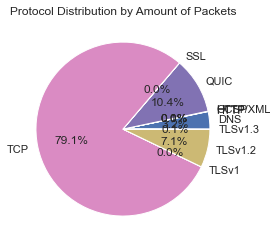

In [4]:
print(df.groupby('Protocol').Source.count())

count_protocol_packets = df.groupby('Protocol').Source.count()

fig, ax = plt.subplots()
plt.title('Protocol Distribution by Amount of Packets')
ax.pie(count_protocol_packets, labels=count_protocol_packets.keys(), autopct='%1.1f%%',)
fig.show()

### Amount of data traffic per protocol ###

Protocol
DNS           5278304
HTTP           211089
HTTP/XML         5660
OCSP           152386
QUIC         23494707
SSL             34294
TCP         116931865
TLSv1           49094
TLSv1.2      34237019
TLSv1.3        251911
Name: Length, dtype: int64


C:\Users\maxim\AppData\Local\Temp/ipykernel_21772/3869399598.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


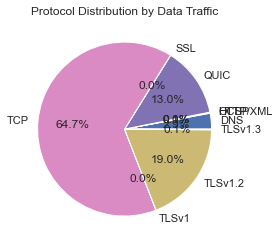

In [5]:
count_protocol_traffic = df.groupby('Protocol').Length.sum()
print(count_protocol_traffic)
fig, ax = plt.subplots()
plt.title('Protocol Distribution by Data Traffic')
ax.pie(count_protocol_traffic, labels=count_protocol_traffic.keys(), autopct='%1.1f%%',)
fig.show()

### Average Data length per Protocol Type ###

Protocol
DNS         134.781268
HTTP        308.159124
HTTP/XML    566.000000
OCSP        499.626230
QUIC        186.073108
SSL         176.773196
TCP         122.023923
TLSv1       434.460177
TLSv1.2     400.227006
TLSv1.3     276.521405
Name: Length, dtype: float64


C:\Users\maxim\AppData\Local\Temp/ipykernel_21772/687483302.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


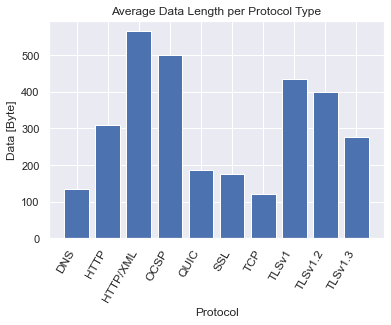

In [6]:
average_protocol_packet_length = df.groupby('Protocol').Length.sum() / df.groupby('Protocol').Length.count()
print(average_protocol_packet_length)
fig, ax = plt.subplots()
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='x', which='minor', labelsize=12)
plt.xlabel('Protocol')
plt.ylabel('Data [Byte]')
plt.title('Average Data Length per Protocol Type')
ax.bar(average_protocol_packet_length.keys(), average_protocol_packet_length, align='center',)
plt.xticks(rotation=60, ha="right")
fig.show()

### Source addresses ###

In [7]:
print(df.groupby('Source').Time.count())
print(df.groupby('Destination').Time.count().sort_values())

unique_dests = df['Destination'].unique()

# write ip address destinations to file
file1 = open("Testfile.txt","w")
for row in unique_dests:
    file1.write(row + "\n")
file1.close()

Source
192.168.178.1                              8244
192.168.178.21                           131325
192.168.178.59                           549358
192.168.178.63                                4
2001:4860:4860::8888                         13
2003:c1:3712:ac00:34ed:a150:b6ea:7073        75
2003:c1:3712:ac00:417b:1f59:95f2:e865    265195
2003:c1:3712:ac00:9582:4ed2:3d23:a4b3      2590
2003:c1:3712:ac00:9d5:78bf:3d44:cc4d        198
2003:c1:3712:ac00:bc3b:27ac:c9a0:280c    122357
2003:c1:3712:ac00:bc7b:5afb:52f8:f45f     88636
2003:c1:3712:ac00:e228:6dff:fe67:1d98       498
2003:c1:3712:ac00:fcba:b34:279a:9bc8      30610
45.146.165.37                                 3
8.8.4.4                                       1
8.8.8.8                                      13
fd00::e228:6dff:fe67:1d98                 12340
Name: Time, dtype: int64
Destination
99.84.91.123                1
52.114.74.223               1
8.8.4.4                     1
2606:4700::6812:bcf         1
104.26.6.62         

### DNS requests ###

In [8]:
df_dns = df[df['Protocol'].isin(['DNS'])]
df_dns.head()
df_dns_requests_1 = df_dns[df_dns['Info'].str.contains('Standard query')]
# does not contain response
df_dns_requests_2 = df_dns_requests_1[~df_dns_requests_1['Info'].str.contains('response')]
df_dns_resources = df_dns_requests_2['Info'].apply(lambda x: x.split(' ')[-1]).value_counts()
print(df_dns_resources)
# print(df_dns_requests)
# print(df_dns['Info'])


BRW68140127B12B.fritz.box                                                   3150
i.redd.it                                                                    493
oauth.reddit.com                                                             450
gql.reddit.com                                                               448
wpad.fritz.box                                                               440
                                                                            ... 
d3320906ov4soz.cloudfront.net                                                  1
63.178.168.192.in-addr.arpa                                                    1
10.0.168.192.in-addr.arpa                                                      1
e.b.c.7.8.9.e.f.f.f.b.e.7.2.a.b.0.0.c.a.2.1.7.3.1.c.0.0.3.0.0.2.ip6.arpa       1
e.b.c.7.8.9.e.f.f.f.b.e.7.2.a.b.0.0.0.0.0.0.0.0.0.0.0.0.0.8.e.f.ip6.arpa       1
Name: Info, Length: 862, dtype: int64


### IP Wordlwide location

In [9]:
df_destinations =  df['Destination'].unique()

for dest in df_destinations[:10]: # 10 entries limit for now
    if dest.startswith("192.168"):
            continue
    headers = { 'User-Agent': "keycdn-tools:https://www.example.com" }
    url = "https://tools.keycdn.com/geo.json?host={}".format(dest)
    r = requests.get(url, headers=headers)
    print(r.json() )  


{'status': 'success', 'description': 'Data successfully received.', 'data': {'geo': {'host': '2607:ff18:80::3b8e', 'ip': '2607:ff18:80::3b8e', 'rdns': '2607:ff18:80::3b8e', 'asn': 40630, 'isp': 'GRIDFURY-AS', 'country_name': 'United States', 'country_code': 'US', 'region_name': None, 'region_code': None, 'city': None, 'postal_code': None, 'continent_name': 'North America', 'continent_code': 'NA', 'latitude': 37.751, 'longitude': -97.822, 'metro_code': None, 'timezone': 'America/Chicago', 'datetime': '2022-01-17 11:16:53'}}}
{'status': 'success', 'description': 'Data successfully received.', 'data': {'geo': {'host': '2a00:1450:4001:812::2004', 'ip': '2a00:1450:4001:812::2004', 'rdns': 'fra16s52-in-x04.1e100.net', 'asn': 15169, 'isp': 'GOOGLE', 'country_name': 'Germany', 'country_code': 'DE', 'region_name': 'Hesse', 'region_code': 'HE', 'city': 'Frankfurt am Main', 'postal_code': '60313', 'continent_name': 'Europe', 'continent_code': 'EU', 'latitude': 50.1188, 'longitude': 8.6843, 'metro

### Data traffic over time ###

from  1641256562  to  1641342910
97
[1.29740e+04 3.56680e+04 1.28230e+04 6.88000e+02 6.80000e+01 1.76230e+04
 4.90000e+01 1.40000e+01 4.60000e+01 2.70000e+01 1.80000e+01 5.54000e+02
 1.90000e+01 3.20000e+01 2.30000e+01 3.40000e+01 1.20000e+01 3.00000e+01
 1.70000e+01 4.54000e+02 2.00000e+01 3.00000e+01 1.60000e+01 2.09000e+02
 1.31660e+04 1.33820e+04 2.33290e+04 2.74100e+04 6.92620e+04 1.31179e+05
 1.58070e+04 4.13690e+04 3.12450e+04 2.49190e+04 3.58000e+02 2.09300e+03
 8.43000e+02 5.31000e+02 3.04000e+02 1.09400e+03 7.69000e+02 1.58290e+04
 1.54610e+04 4.45000e+02 4.99370e+04 3.74560e+04 1.75190e+04 3.59670e+04
 4.43170e+04 3.18330e+04 3.11840e+04 1.92110e+04 2.30630e+04 2.86440e+04
 5.67460e+04 4.73090e+04 4.52020e+04 1.13670e+04 3.95800e+03 1.52210e+04
 6.87100e+03 9.96900e+03 1.52700e+04 2.03200e+03 6.60000e+02 7.37000e+02
 4.51000e+02 1.89800e+03 6.61100e+03 1.50350e+04 7.88000e+03 3.46290e+04
 4.12070e+04 2.90810e+04 3.21000e+02 5.80000e+01 2.76000e+02 3.23000e+02
 4.60000e+01 4.

C:\Users\maxim\AppData\Local\Temp/ipykernel_21772/2614995985.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\maxim\AppData\Local\Temp/ipykernel_21772/2614995985.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


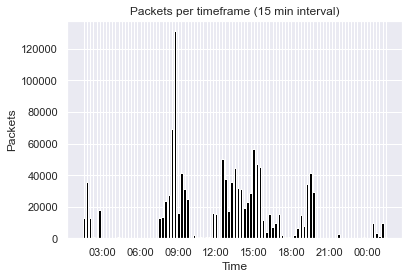

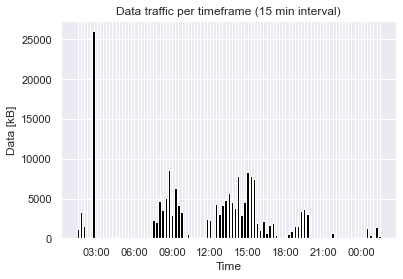

In [10]:
def timeMapping(x):
    # include time difference UTC+1
    time = datetime.utcfromtimestamp(x*min_15_duration + 3600)
    if time.minute == 0 and time.hour % 3 == 0:
        return time.strftime("%H:%M")
    else:
        return ""

# find first and last timestamp, then create data structure
min_15_duration = 60 * 15
df_time_mod = df.copy()
df_time_mod['Time'] = df_time_mod['Time'].apply(lambda x: utcEntryToTimestamp(x)) # map to 15 min window
df_time_mod.head()
first_entry = df_time_mod.loc[0].at['Time'] // min_15_duration
last_entry = df_time_mod.iloc[-1].at['Time'] // min_15_duration

print('from ', df_time_mod.loc[0].at['Time'], " to ", df_time_mod.iloc[-1].at['Time'])

count_packets = np.zeros(last_entry - first_entry + 1)
length_packets = np.zeros(last_entry - first_entry + 1)

x_values_packets = list(range(first_entry, last_entry + 1))
print(len(x_values_packets))

mapping_res = list(map(timeMapping, x_values_packets))

# print(mapping_res)

for index, row in df_time_mod.iterrows():
    ts = row.at['Time'] // min_15_duration
    count_packets[ts - first_entry] += 1
    length_packets[ts - first_entry] += row.at['Length']

length_packets = length_packets // 1000
print(count_packets)
print(length_packets)

fig, ax = plt.subplots()
plt.xlabel('Time')
plt.ylabel('Packets')
plt.title('Packets per timeframe (15 min interval)')
plt.xticks(x_values_packets, mapping_res)
ax.bar(x_values_packets, count_packets, color='black')
fig.show()

fig, ax = plt.subplots()
plt.xlabel('Time')
plt.ylabel('Data [kB]')
plt.title('Data traffic per timeframe (15 min interval)')
plt.xticks(x_values_packets, mapping_res)
ax.bar(x_values_packets, length_packets, color='black')
fig.show()